In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("../Lab1/fulldata.csv")
data.head()

Unnamed: 0     lat_     lon_  State_  Ta_mean  Ta_min  Ta_max  Tsurf_mean  \
0           0  68.0926  16.3644       3     14.1    14.1    14.1    1.675000   
1           1  68.0926  16.3645       3     14.1    14.1    14.1    1.787778   
2           2  68.0926  16.3646       3     14.1    14.1    14.1    2.050000   
3           3  68.0926  16.3647       3     14.1    14.1    14.1    1.920000   
4           4  68.0926  16.3648       3     14.1    14.1    14.1    1.550000   

   Tsurf_min  Tsurf_max  ...  WindGustKmph  cloudcover  humidity  precipMM  \
0       1.61       1.74  ...            36          63        69       0.0   
1       1.55       1.98  ...            36          63        69       0.0   
2       2.05       2.05  ...            36          63        69       0.0   
3       1.92       1.92  ...            36          63        69       0.0   
4       1.55       1.55  ...            36          63        69       0.0   

   pressure  tempC  visibility  winddirDegree  windspeedKmph  location  
0      1000     -5          10            152             17  kjopsvik  
1      1000     -5          10            152             17  kjopsvik  
2      1000     -5          10            152             17  kjopsvik  
3      1000     -5          10            152             17  kjopsvik  
4      1000     -5          10            152             17  kjopsvik  

[5 rows x 56 columns]

In [3]:
datas = data.sort_values(by = ['Date', 'Time'])

In [4]:
datas.head()

Unnamed: 0     lat_     lon_  State_    Ta_mean  Ta_min  Ta_max  \
159111      159111  68.4516  17.5419       3  11.487162     2.6    15.3   
159112      159112  68.4516  17.5422       3  16.359036     2.9    19.5   
159116      159116  68.4516  17.5426       3  14.879070    -6.4    19.7   
159115      159115  68.4516  17.5425       3  18.413559     2.9    19.7   
159114      159114  68.4516  17.5424       3  15.258537     2.9    19.5   

        Tsurf_mean  Tsurf_min  Tsurf_max  ...  WindGustKmph  cloudcover  \
159111    2.378784      -0.04       4.35  ...            30          51   
159112    4.018675      -1.14       5.91  ...            30          51   
159116    3.796744      -7.30       6.31  ...            30          51   
159115    5.139068       0.10       6.28  ...            30          51   
159114    3.798537      -0.80       6.40  ...            30          51   

        humidity  precipMM  pressure  tempC  visibility  winddirDegree  \
159111        72       0.0      1007      1          10            149   
159112        72       0.0      1007      1          10            149   
159116        72       0.0      1007      1          10            149   
159115        72       0.0      1007      1          10            149   
159114        72       0.0      1007      1          10            149   

        windspeedKmph  location  
159111             15    oyjord  
159112             15    oyjord  
159116             15    oyjord  
159115             15    oyjord  
159114             15    oyjord  

[5 rows x 56 columns]

In [5]:
predictors = ['Height_mean', 'Speed_mean']
target = ['Friction_mean', 'Water_mean', 'Tsurf_mean']

In [6]:
datas['Time'].info

<bound method Series.info of 159111    06:51:34
159112    06:54:50
159116    06:55:02
159115    06:55:05
159114    06:55:06
            ...   
95245     15:22:00
95247     15:22:02
95248     15:22:04
95249     15:22:05
95250     15:22:06
Name: Time, Length: 196133, dtype: object>

In [7]:
pd.to_datetime(datas['date_time'])

159111   2020-11-30 06:00:00
159112   2020-11-30 06:00:00
159116   2020-11-30 06:00:00
159115   2020-11-30 06:00:00
159114   2020-11-30 06:00:00
                 ...        
95245    2021-03-03 15:00:00
95247    2021-03-03 15:00:00
95248    2021-03-03 15:00:00
95249    2021-03-03 15:00:00
95250    2021-03-03 15:00:00
Name: date_time, Length: 196133, dtype: datetime64[ns]

In [8]:
def getDateTime(row):
    return '-'.join(row['Date'].split('.')) + " " + row['Time']

In [9]:
times = pd.to_datetime(datas.apply(getDateTime, axis=1))

In [10]:
datas['times'] = times
datas_subs = datas[['times']+target+predictors]

In [11]:
fdata = datas_subs.resample("180S", on = 'times').mean()[:300]

In [12]:
fdata.reset_index(inplace=True)

In [13]:
fdata.head()

times  Friction_mean  Water_mean  Tsurf_mean  Height_mean  \
0 2020-11-30 06:51:00       0.668041    0.348270    2.378784   119.716216   
1 2020-11-30 06:54:00       0.657400    0.396293    0.886534   111.842536   
2 2020-11-30 06:57:00       0.674035    0.253542    0.276387    66.135803   
3 2020-11-30 07:00:00       0.671570    0.241061    0.615723    54.376604   
4 2020-11-30 07:03:00       0.685286    0.215836   -0.580710    67.556196   

   Speed_mean  
0    1.015541  
1   22.251895  
2   43.086703  
3   60.944598  
4   39.791792

По умолчанию тренды приближаем с помощью полиномов 9-ой степени

In [14]:
def rolling_fillna(series: pd.Series, window=5):
    ans = series
    for i in range(window,series.shape[0]):
        ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]
    return ans

def determinetrend(data: pd.Series, order=9):
    trend = np.polyfit(data.index.values, data.tolist(), order)
    return np.poly1d(trend)(data.index.values)

Графики рядов с их выученными трендами

C:\Users\Acer\AppData\Local\Temp\ipykernel_13824\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]
C:\Users\Acer\AppData\Local\Temp\ipykernel_13824\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]
C:\Users\Acer\AppData\Local\Temp\ipykernel_13824\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

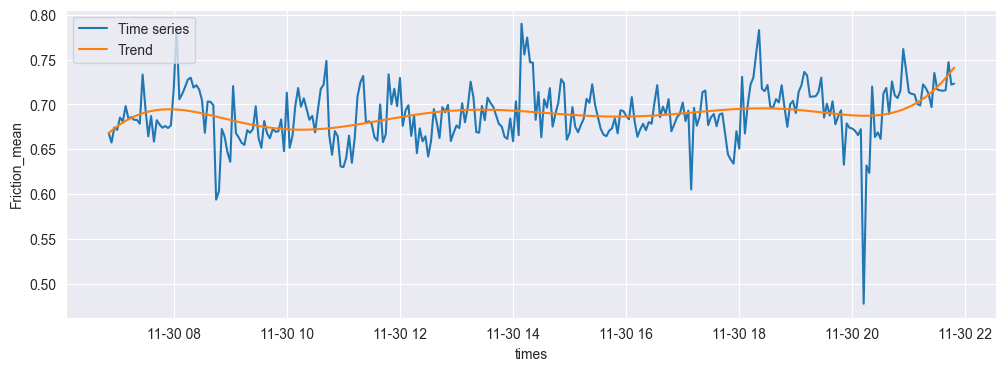

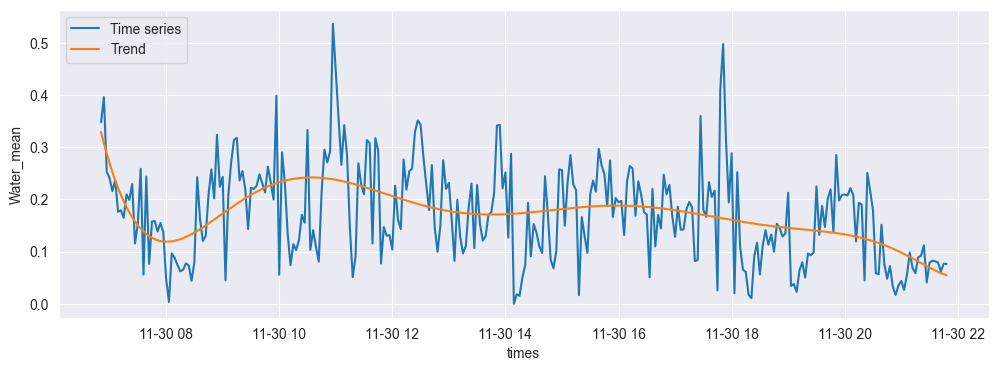

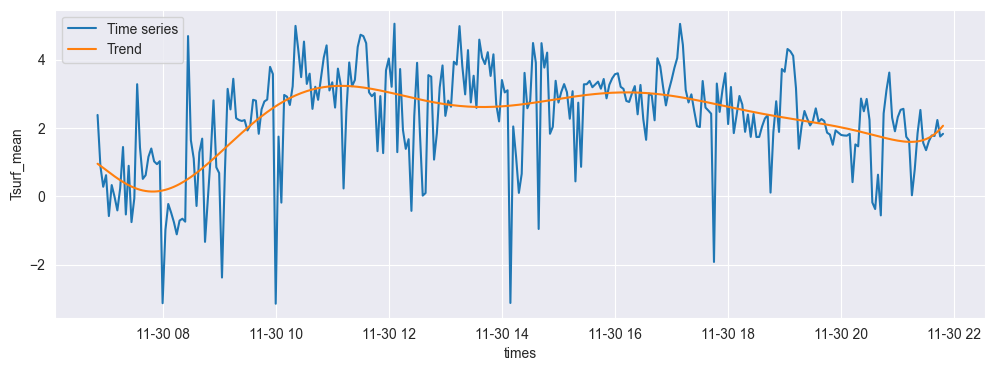

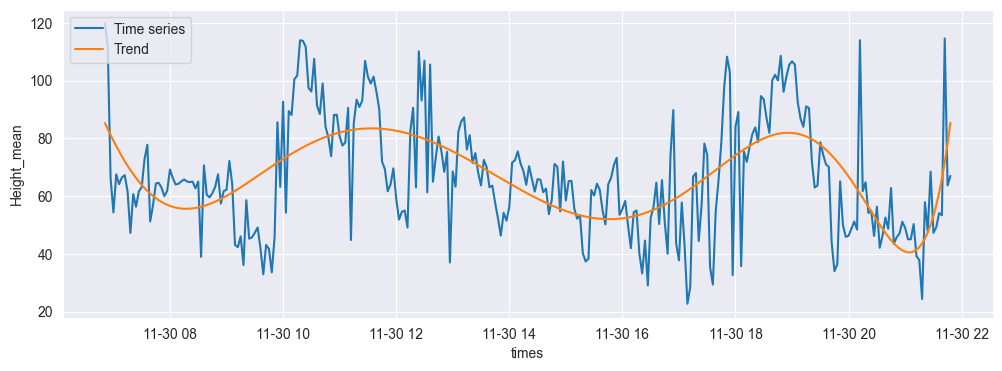

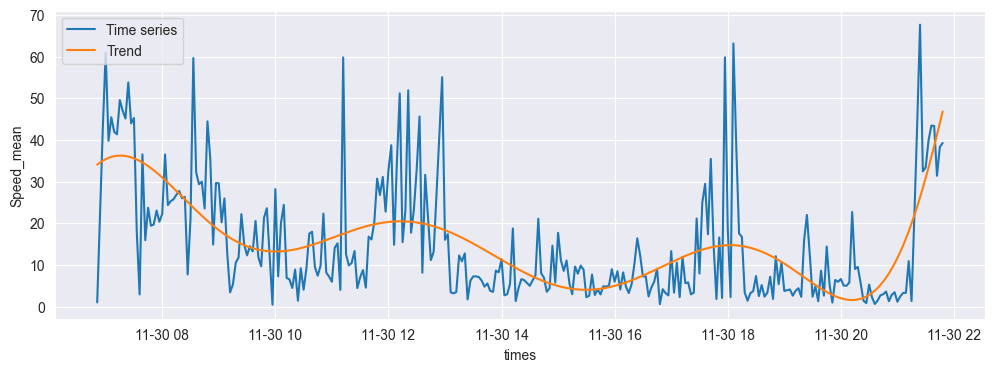

In [15]:
for feat in target+predictors:
    d = rolling_fillna(fdata[feat])

    plt.figure(figsize=(12,4), dpi= 100)

    trend = determinetrend(d)

    sns.lineplot(x=fdata['times'], y=d, label='Time series')
    sns.lineplot(x=fdata['times'], y=trend, label='Trend')
    plt.legend(loc = 2)

In [16]:
numbers = np.array(list(range(1, 301)), dtype = int)

Присутствие трендов убрано. Здесь смотрим на получившиеся ряды и оценку функции среднего

C:\Users\Acer\AppData\Local\Temp\ipykernel_13824\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]
C:\Users\Acer\AppData\Local\Temp\ipykernel_13824\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]
C:\Users\Acer\AppData\Local\Temp\ipykernel_13824\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

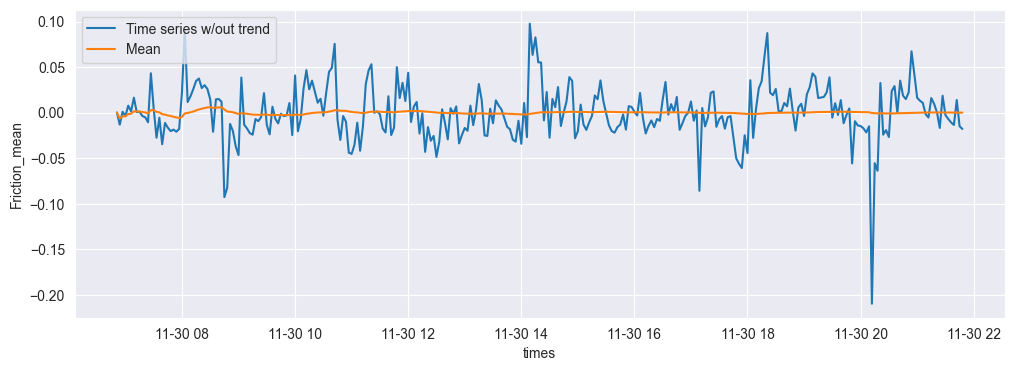

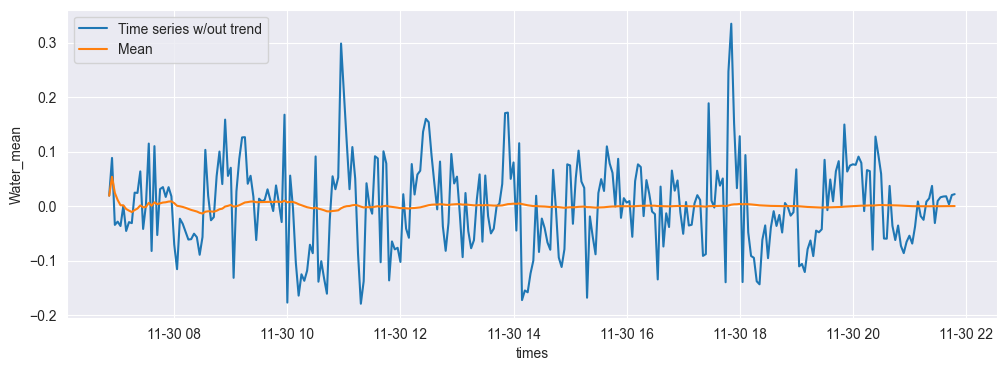

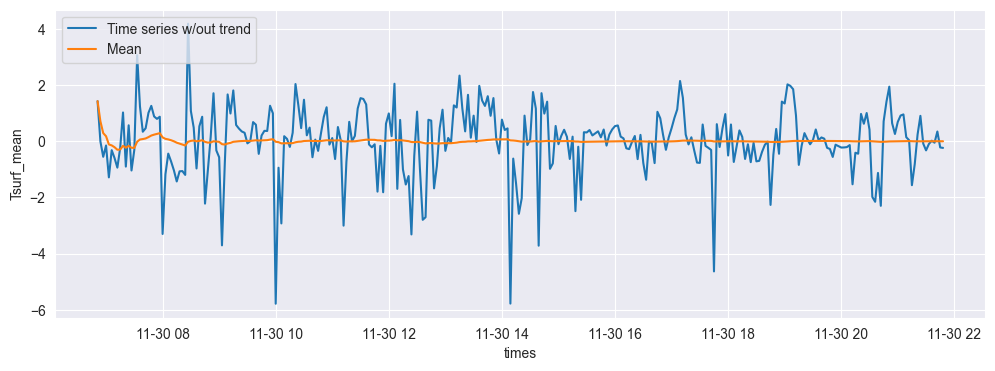

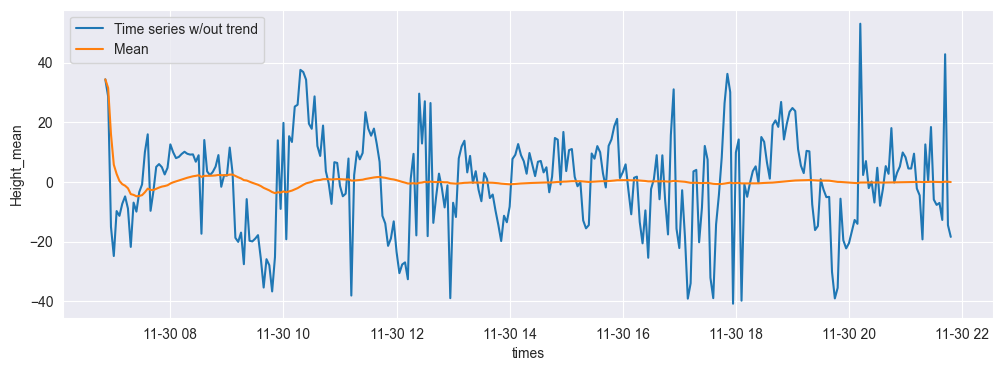

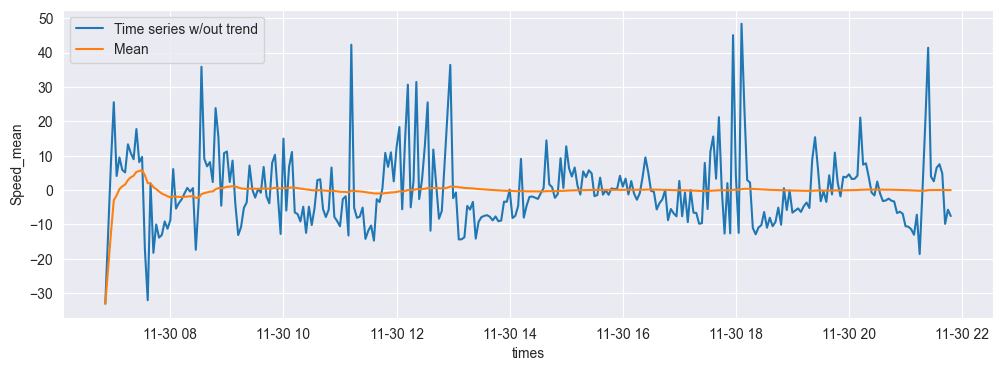

In [17]:
for feat in target+predictors:
    d = rolling_fillna(fdata[feat])

    plt.figure(figsize=(12,4), dpi= 100)

    trend = determinetrend(d)

    dwout = d - trend

    mean = dwout.cumsum()/numbers

    sns.lineplot(x=fdata['times'], y=dwout, label='Time series w/out trend')
    sns.lineplot(x=fdata['times'], y=mean, label='Mean')
    plt.legend(loc = 2)

Здесь смотрим на функции дисперсии у этих рядов.

C:\Users\Acer\AppData\Local\Temp\ipykernel_13824\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Acer\AppData\Local\Temp\ipykernel_13824\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored 

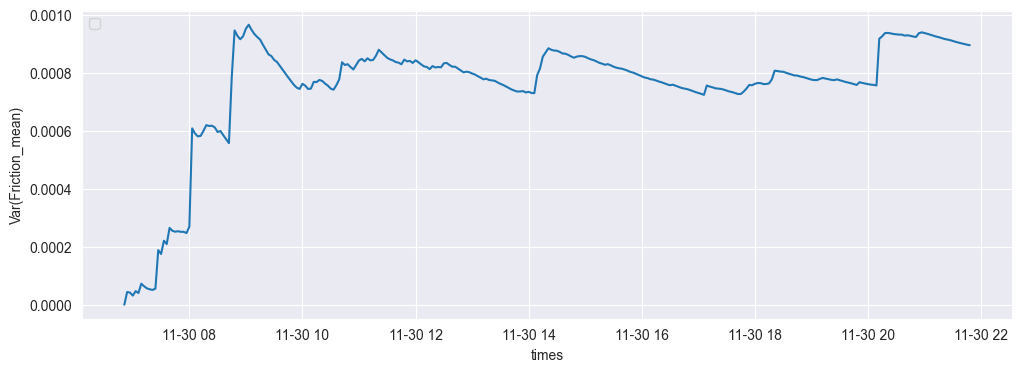

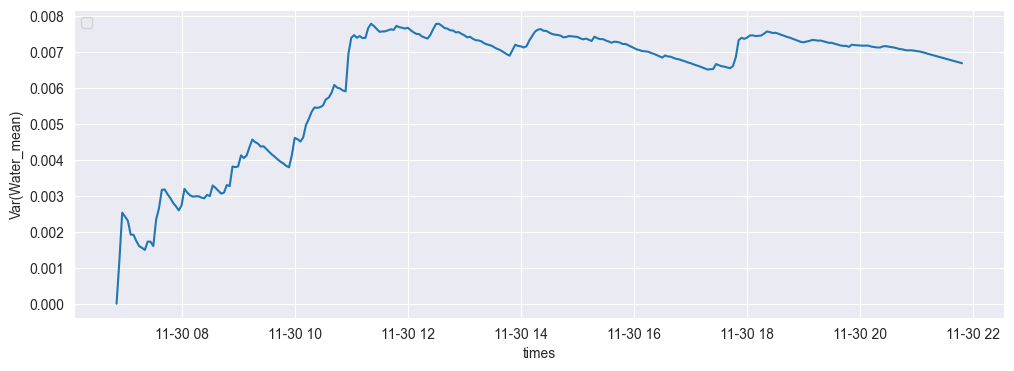

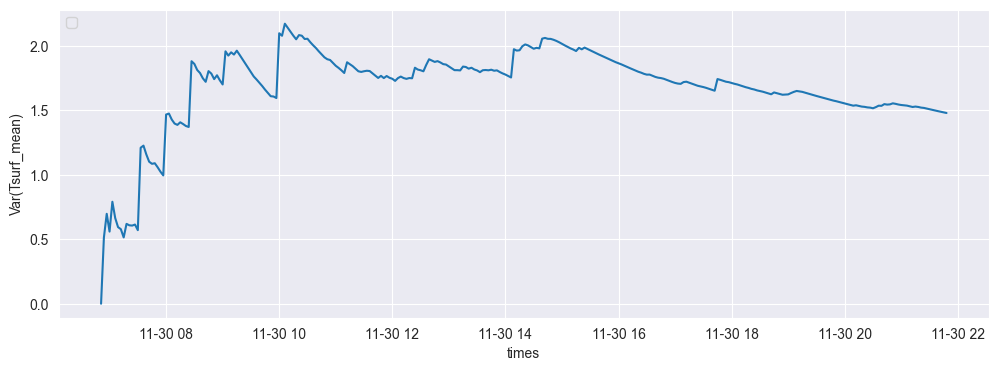

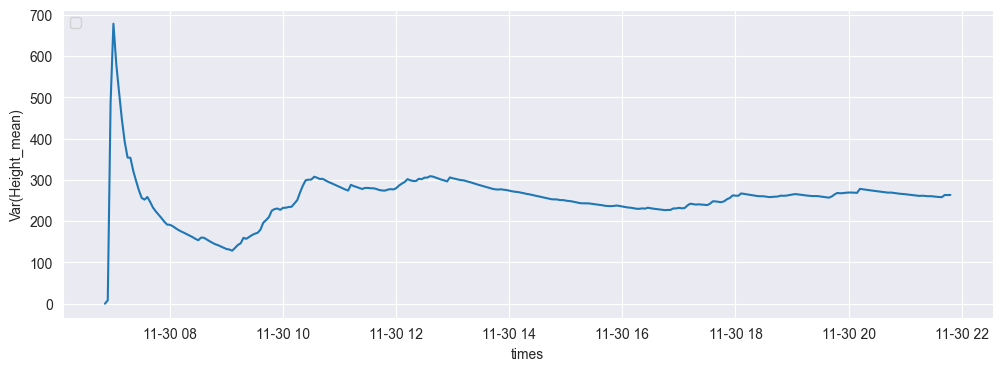

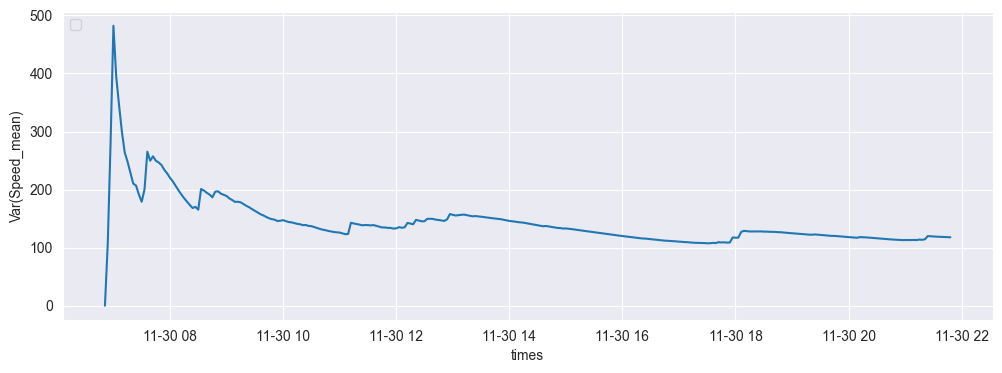

In [18]:
for feat in target+predictors:
    d = rolling_fillna(fdata[feat])

    plt.figure(figsize=(12,4), dpi= 100)

    trend = determinetrend(d)

    dwout = d - trend

    var = (dwout**2).cumsum()/numbers - (dwout.cumsum()/numbers)**2

    sns.lineplot(x=fdata['times'], y=var)
    plt.ylabel("Var("+feat+")")
    plt.legend(loc = 2)

In [19]:
from statsmodels.tsa.stattools import acf, pacf, acovf, ccovf, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

А здесь на автоковариации

C:\Users\Acer\AppData\Local\Temp\ipykernel_13824\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Acer\AppData\Local\Temp\ipykernel_13824\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored 

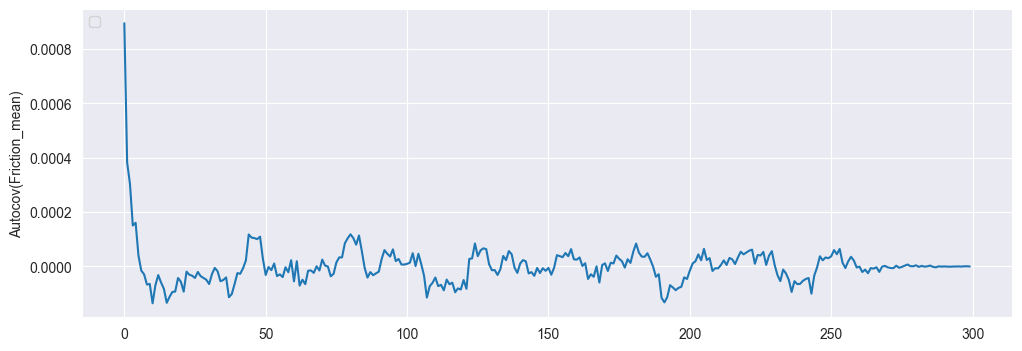

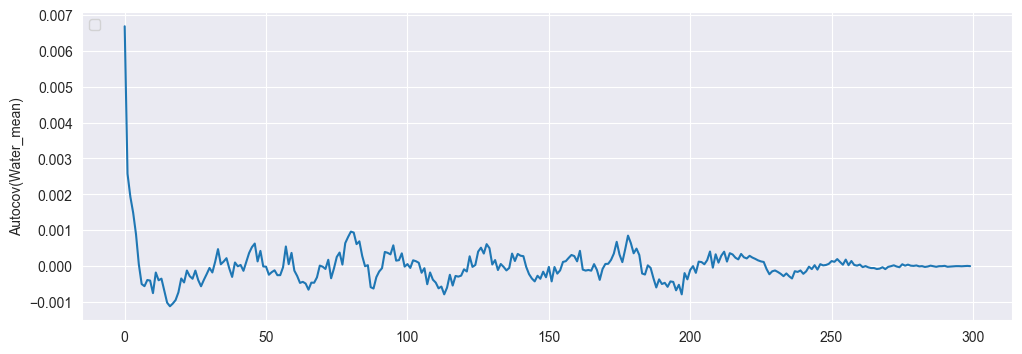

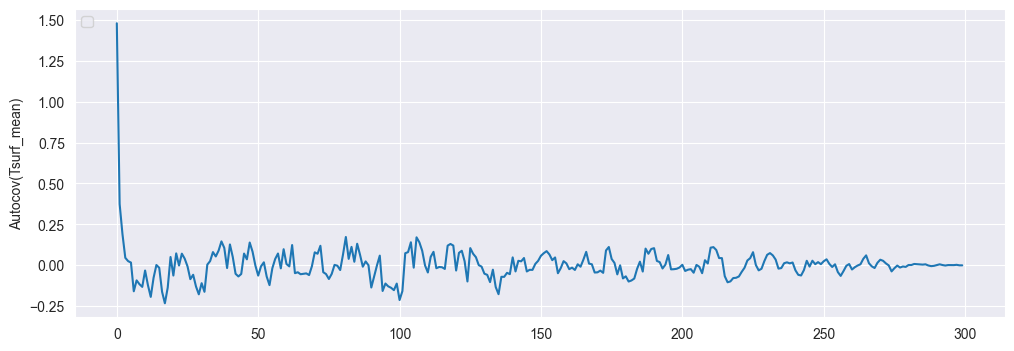

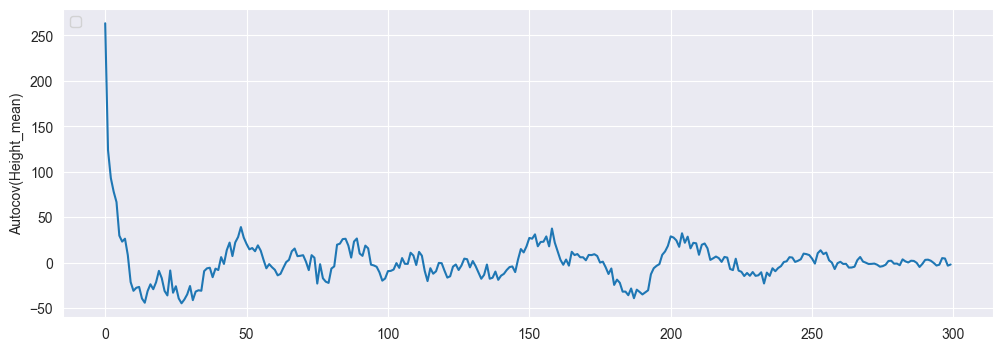

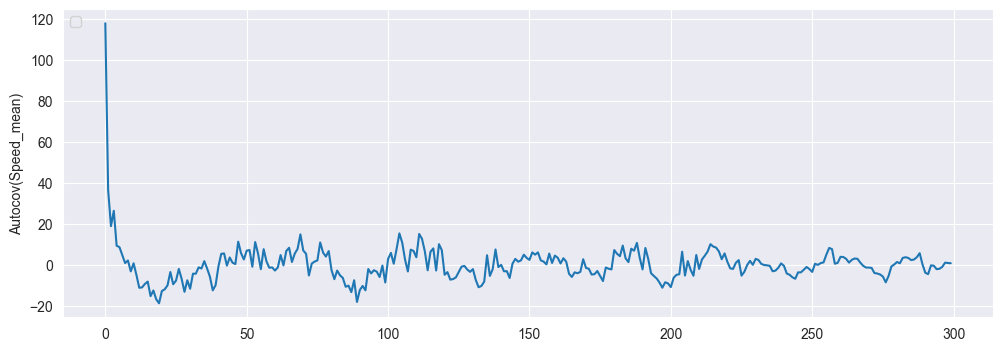

In [20]:
for feat in target+predictors:
    d = rolling_fillna(fdata[feat])

    plt.figure(figsize=(12,4), dpi= 100)

    trend = determinetrend(d)

    dwout = d - trend

    sns.lineplot(acovf(dwout, fft=False))
    plt.ylabel("Autocov("+feat+")")
    plt.legend(loc = 2)

In [21]:
from statsmodels.tsa.stattools import adfuller

In [22]:
for feat in target+predictors:
    d = rolling_fillna(fdata[feat])

    trend = determinetrend(d)

    dwout = d - trend
    print(feat)
    print(adfuller(dwout))



C:\Users\Acer\AppData\Local\Temp\ipykernel_13824\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]
C:\Users\Acer\AppData\Local\Temp\ipykernel_13824\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]
C:\Users\Acer\AppData\Local\Temp\ipykernel_13824\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

Friction_mean
(-7.550400243488283, 3.2001534854724324e-11, 1, 298, {'1%': -3.4524859843440754, '5%': -2.871288184343229, '10%': -2.571964047565425}, -1235.5806467878185)
Water_mean
(-6.734103956919638, 3.24023028074298e-09, 5, 294, {'1%': -3.452789844280995, '5%': -2.871421512222641, '10%': -2.5720351510944512}, -656.9743089600452)
Tsurf_mean
(-13.344201647793428, 5.838729978205566e-25, 0, 299, {'1%': -3.4524113009049935, '5%': -2.8712554127251764, '10%': -2.571946570731871}, 902.2161862337447)
Height_mean
(-5.644384629164311, 1.0192376700780344e-06, 4, 295, {'1%': -3.452713099849546, '5%': -2.871387839457783, '10%': -2.5720171933352485}, 2302.0050274030923)
Speed_mean
(-6.831919769583617, 1.884188960281348e-09, 2, 297, {'1%': -3.4525611751768914, '5%': -2.87132117782556, '10%': -2.5719816428028888}, 2098.70846711092)


C:\Users\Acer\AppData\Local\Temp\ipykernel_13824\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]
C:\Users\Acer\AppData\Local\Temp\ipykernel_13824\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]


In [23]:
trends = dict()
fdata_mod = pd.DataFrame(columns=fdata.columns, index=fdata.index)
fdata_mod['times'] = fdata['times']

for feat in target+predictors:
    d = rolling_fillna(fdata[feat])
    trends[feat] = determinetrend(d)
    fdata_mod[feat] = d - trends[feat]
fdata_mod.head()

C:\Users\Acer\AppData\Local\Temp\ipykernel_13824\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]


times  Friction_mean  Water_mean  Tsurf_mean  Height_mean  \
0 2020-11-30 06:51:00       0.000101    0.019028    1.427731    34.424993   
1 2020-11-30 06:54:00      -0.013167    0.088326   -0.004763    28.651617   
2 2020-11-30 06:57:00       0.000982   -0.034574   -0.553256   -15.021904   
3 2020-11-30 07:00:00      -0.003824   -0.028584   -0.151345   -24.818380   
4 2020-11-30 07:03:00       0.007694   -0.036671   -1.285170    -9.749479   

   Speed_mean  
0  -33.052936  
1  -12.319931  
2    8.078731  
3   25.567747  
4    4.113010

Автоковариации с окнами шириной в 30

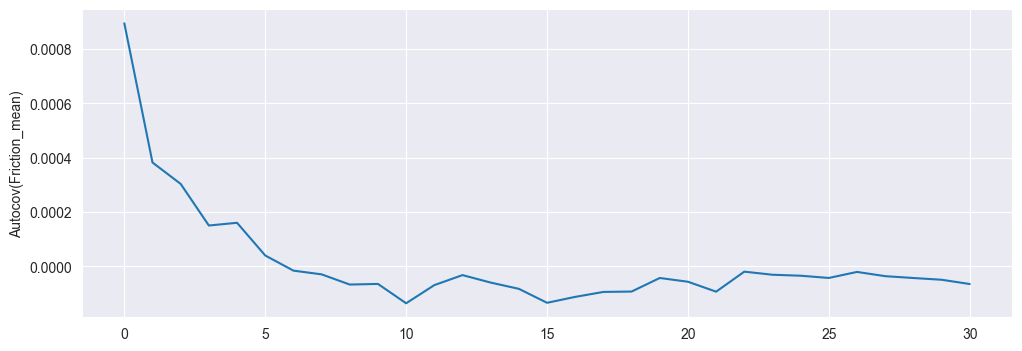

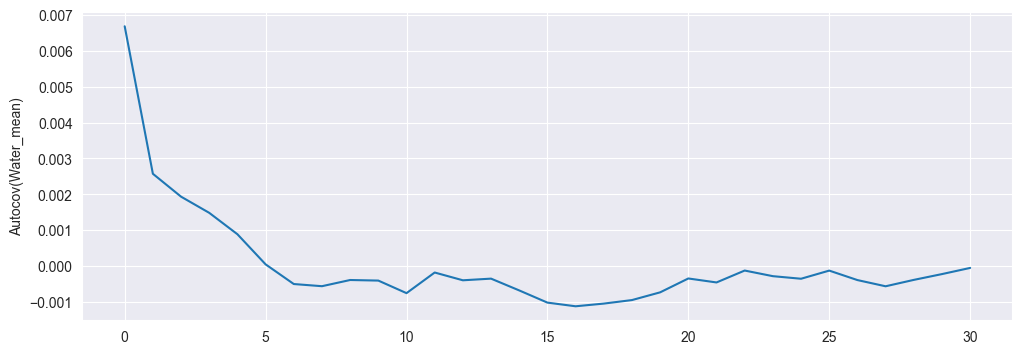

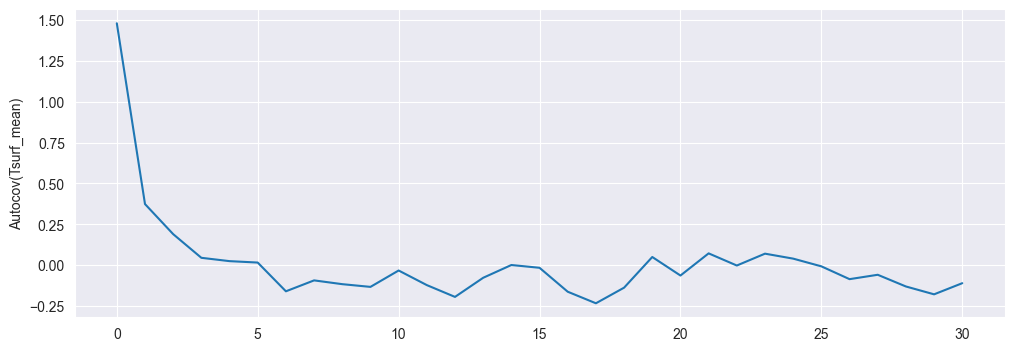

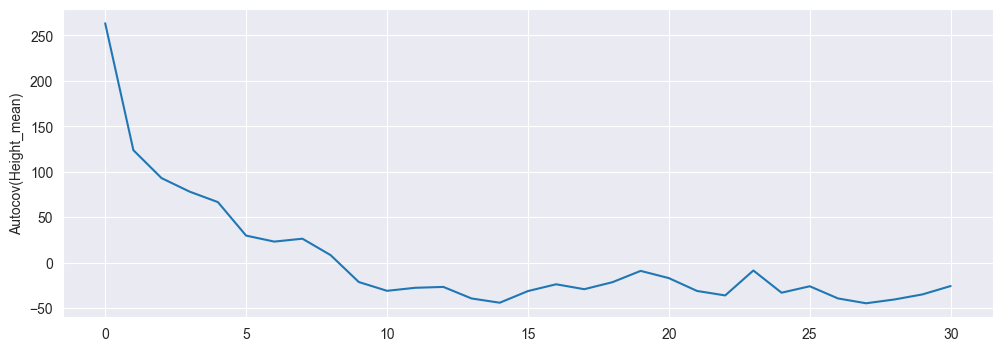

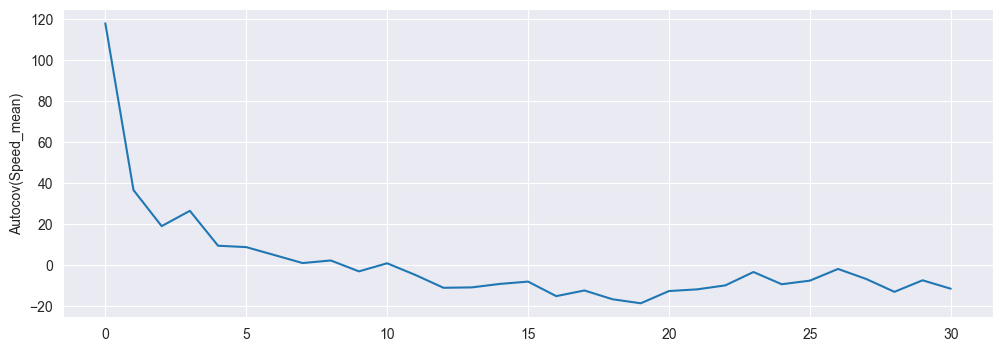

In [24]:
for feat in target+predictors:
    plt.figure(figsize=(12,4), dpi= 100)
    sns.lineplot(acovf(fdata_mod[feat], fft=False, nlag=30))
    plt.ylabel("Autocov("+feat+")")

Кросс-корреляции

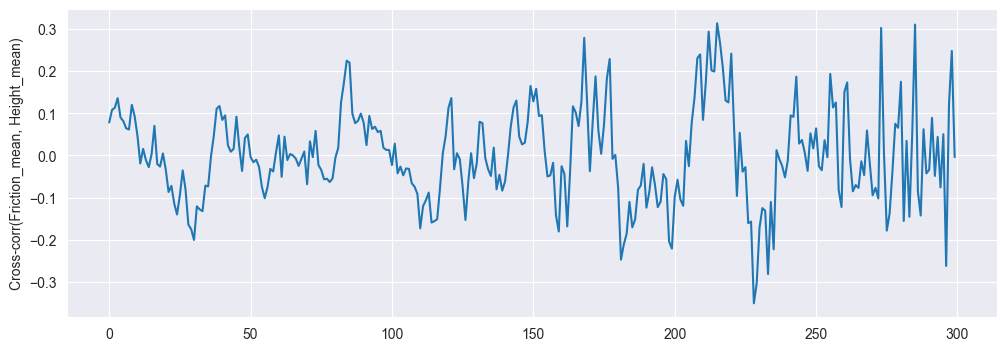

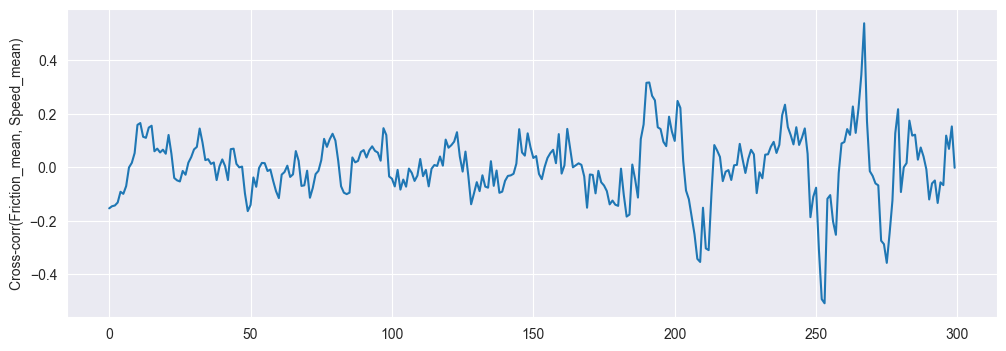

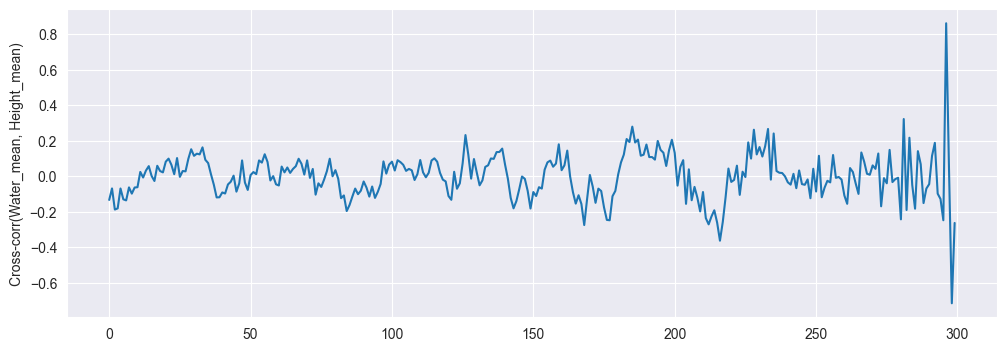

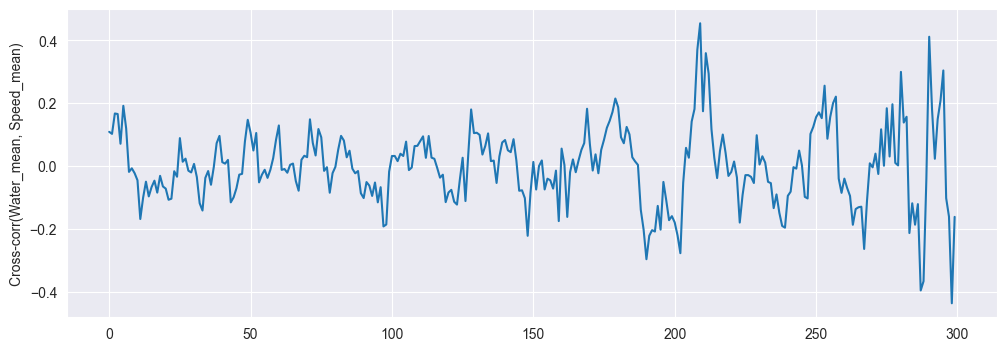

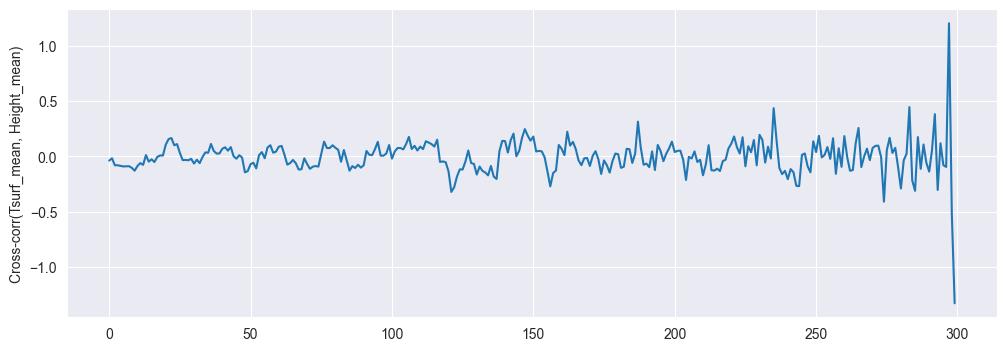

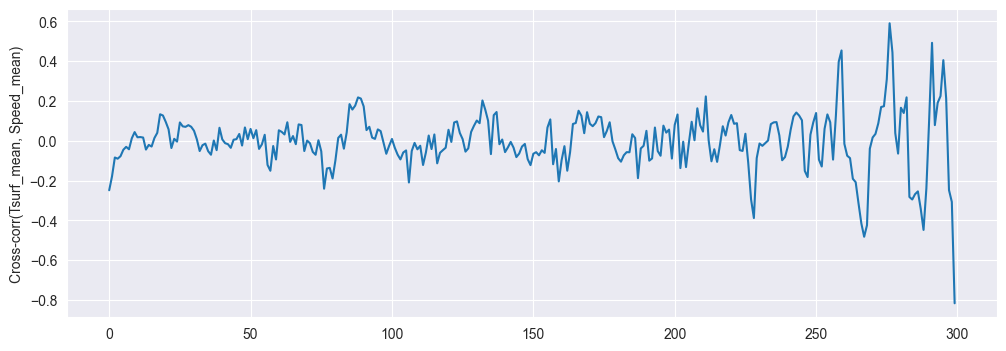

In [25]:
for tar in target:
    for pred in predictors:
        plt.figure(figsize=(12,4), dpi= 100)
        sns.lineplot(ccf(x=fdata_mod[pred], y=fdata_mod[tar], fft=False))
        plt.ylabel("Cross-corr("+tar+", "+pred+")")

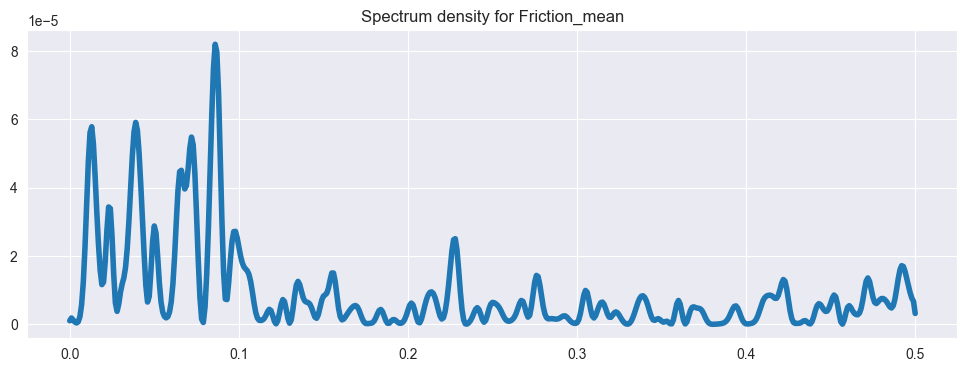

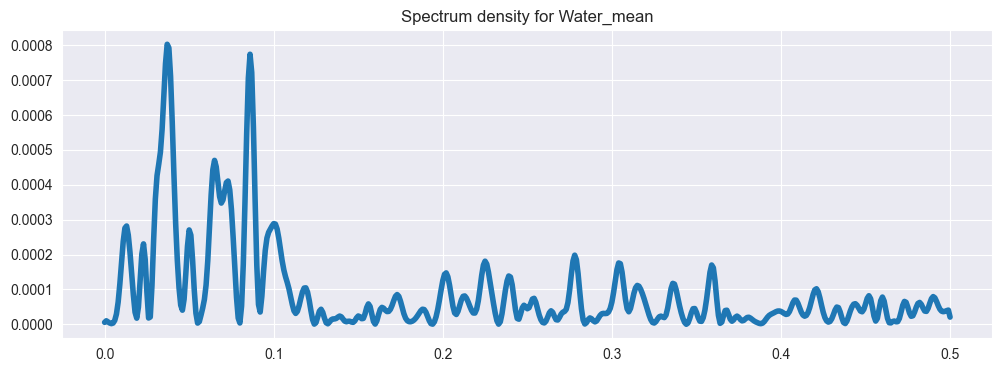

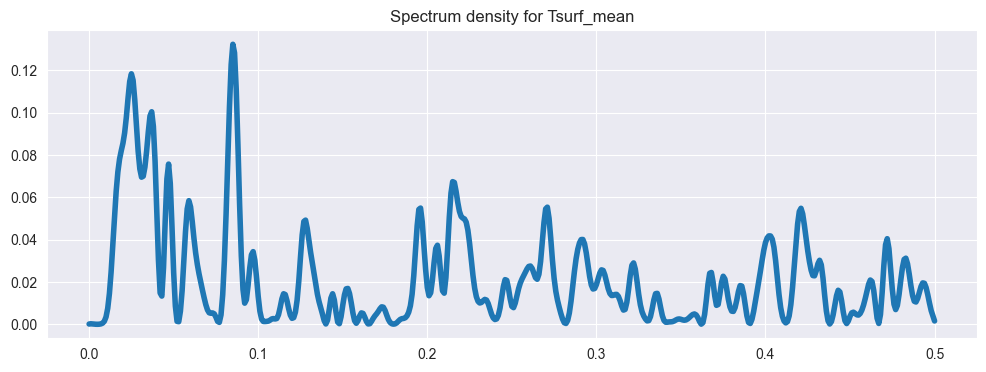

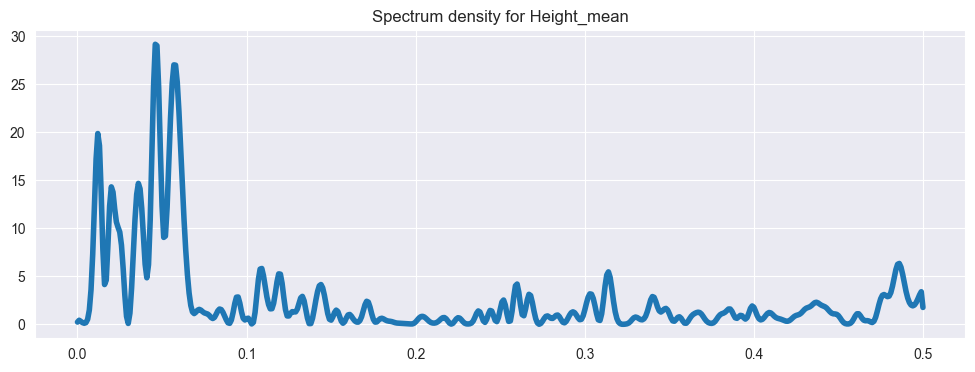

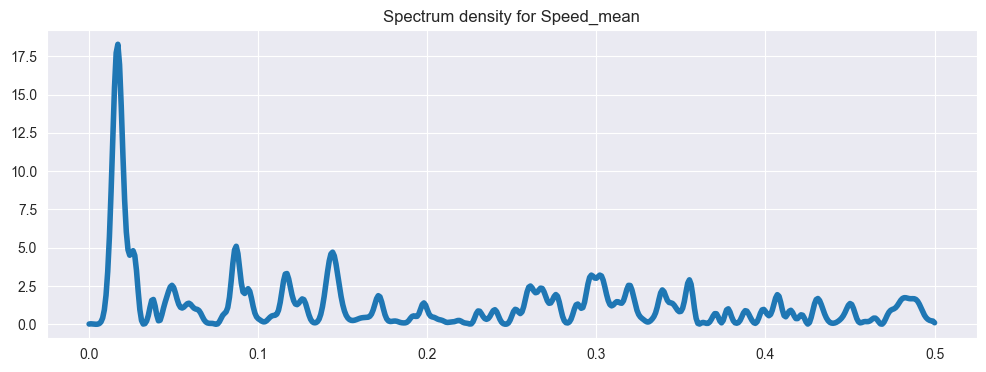

In [26]:
from scipy import signal
blackman = signal.windows.blackman(M=5)
for feat in target+predictors:
    plt.figure(figsize=(12,4), dpi= 100)
    f, Pxx_raw = signal.welch(fdata_mod[feat], fs=1, scaling='spectrum', nfft = 1000)
    plt.plot(f, Pxx_raw, linewidth=4)
    plt.title("Spectrum density for "+feat)

In [37]:
import time
import pmdarima as pm
from sklearn.model_selection import train_test_split




 Friction_mean
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 607.160
Date:                Fri, 09 Dec 2022   AIC                          -1208.321
Time:                        21:52:26   BIC                          -1197.593
Sample:                             0   HQIC                         -1204.010
                                - 264                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3773      0.050      7.516      0.000       0.279       0.476
ar.L2          0.1673      0.060      2.786      0.005       0.050       0.285
sigma2         0.0006   3.45e-05  

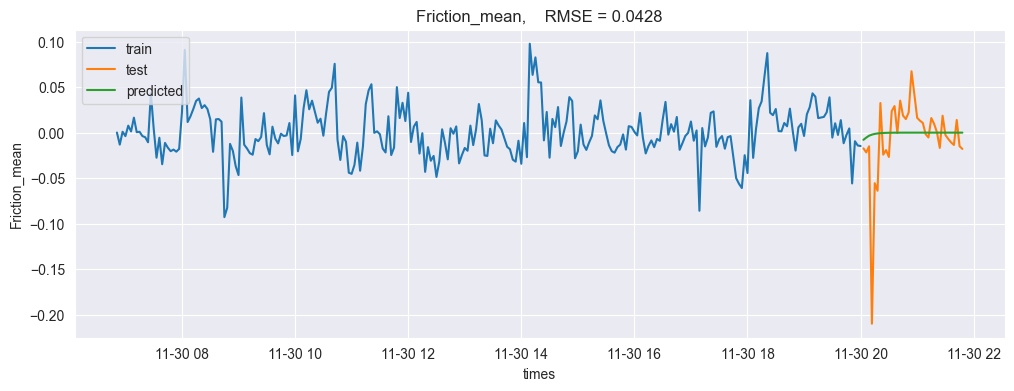

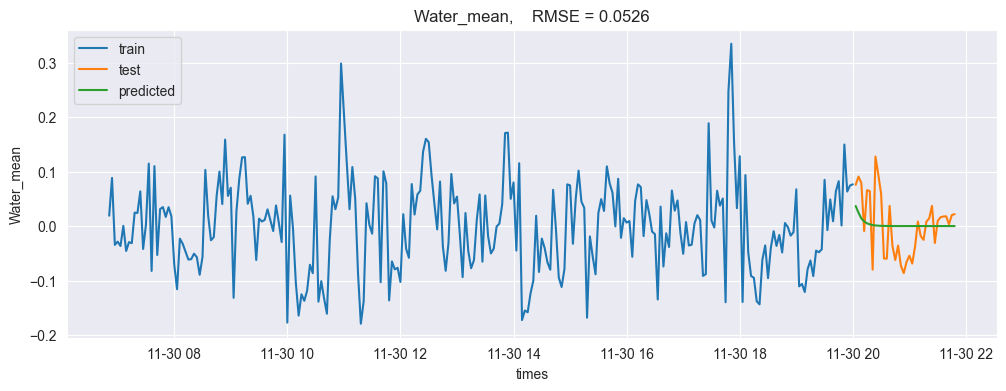

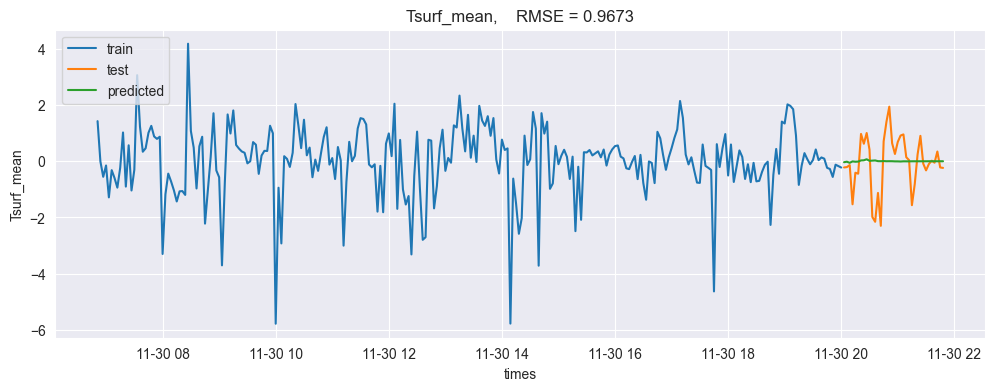

In [38]:
from statsmodels.tools.eval_measures import rmse

for trg in target:
    cur_time = time.time()
    time_train, time_test, trg_train, trg_test = train_test_split(fdata_mod['times'], fdata_mod[trg], test_size=0.12, shuffle=False)

    D = pm.arima.nsdiffs(trg_train, m=12, max_D=5)

    stepwise_model = pm.auto_arima(trg_train, d=0,
                            start_p=1, max_p=12,
                            start_q=1, max_q=12,
                            D=D,
                            m=12,
                            seasonal=True,
                            stationary=True,
                            information_criterion='aic',
                            stepwise=True,
                            suppress_warnings=True)
    print("\n\n\n", trg)

    stepwise_model.fit(trg_train)
    print(stepwise_model.summary(), "\n\n\n")

    pred = stepwise_model.predict(len(trg_test))

    delta_time = time.time() - cur_time
    print(f"ARIMA Model for {trg} done in {delta_time} seconds.")


    plt.figure(figsize=(12,4), dpi= 100)

    RMSE = rmse(pred, trg_test)
    plt.title(f"{trg},    RMSE = {RMSE:.4f}")
    sns.lineplot(x=time_train, y=trg_train, label='train')
    sns.lineplot(x=time_test, y=trg_test, label='test')
    sns.lineplot(x=time_test, y=pred, label='predicted')
    plt.legend(loc = 2)

In [39]:
std = 3
window = 10
fdata_mr = fdata_mod.rolling(window=window, center=True).mean()
fdata_gauss = fdata_mod.rolling(window=window, win_type='gaussian', center=True).mean(std=std)

C:\Users\Acer\AppData\Local\Temp\ipykernel_13824\199929113.py:3: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['times'], dtype='object')
  fdata_mr = fdata_mod.rolling(window=window, center=True).mean()
C:\Users\Acer\AppData\Local\Temp\ipykernel_13824\199929113.py:4: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['times'], dtype='object')
  fdata_gauss = fdata_mod.rolling(window=window, win_type='gaussian', center=True).mean(std=std)


In [40]:
fdata_mr['times'] = fdata['times']
fdata_gauss['times'] = fdata['times']

In [41]:
fdata_mr.dropna(inplace=True)
fdata_mr.head()

Friction_mean  Water_mean  Tsurf_mean  Height_mean  Speed_mean  \
5       0.000726   -0.007418   -0.162867    -4.061660    3.705259   
6       0.000210   -0.006911   -0.395799    -8.194606    7.909427   
7       0.000469   -0.009382   -0.338522   -12.052952   10.918014   
8       0.004692   -0.010127   -0.387197   -10.889269   10.924058   
9       0.005507   -0.007009   -0.402530    -8.488121    9.333363   

                times  
5 2020-11-30 07:06:00  
6 2020-11-30 07:09:00  
7 2020-11-30 07:12:00  
8 2020-11-30 07:15:00  
9 2020-11-30 07:18:00

In [42]:
fdata_gauss.dropna(inplace=True)

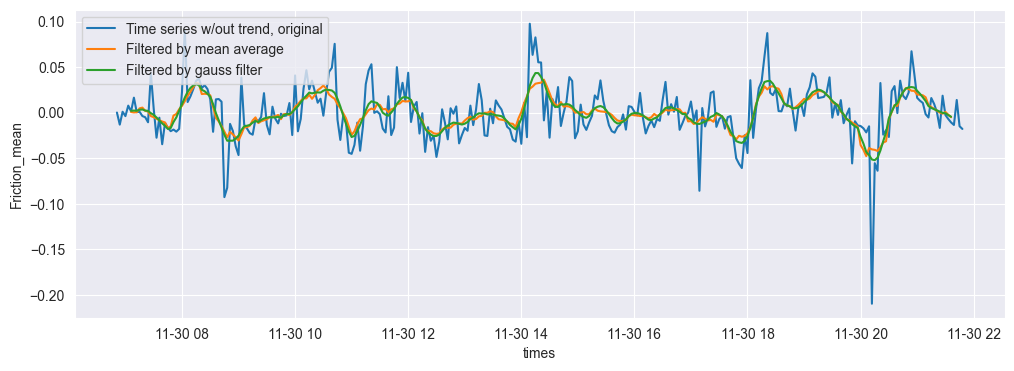

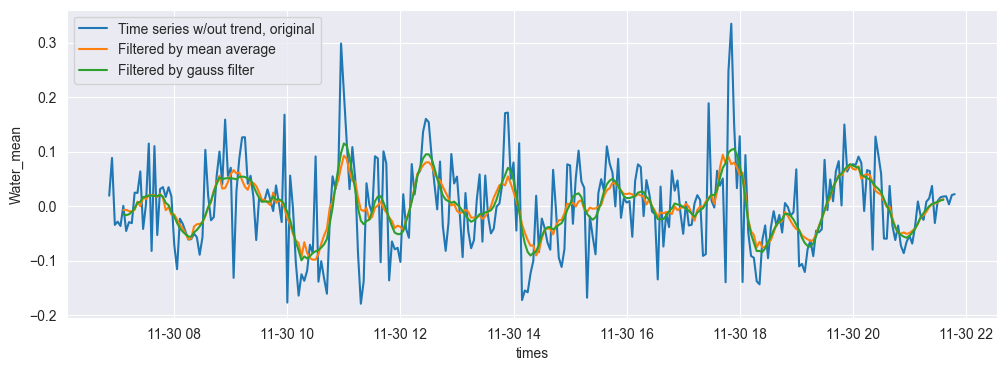

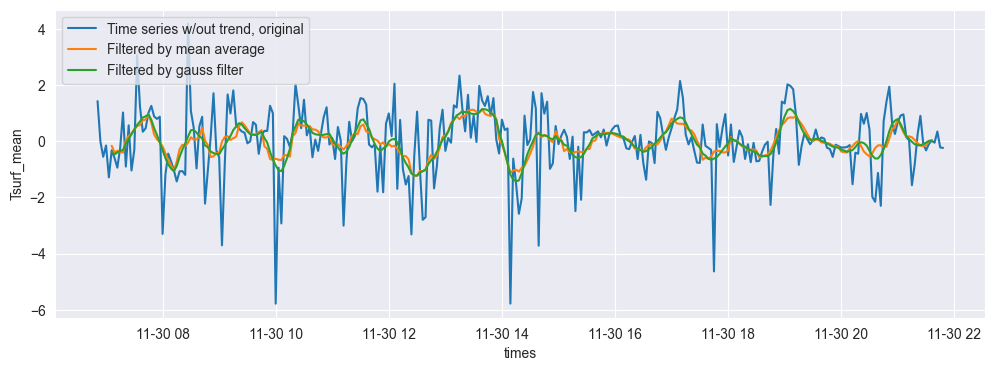

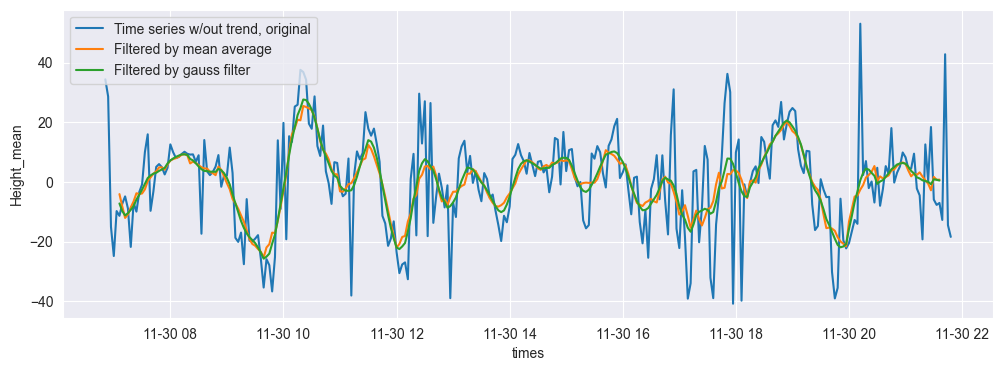

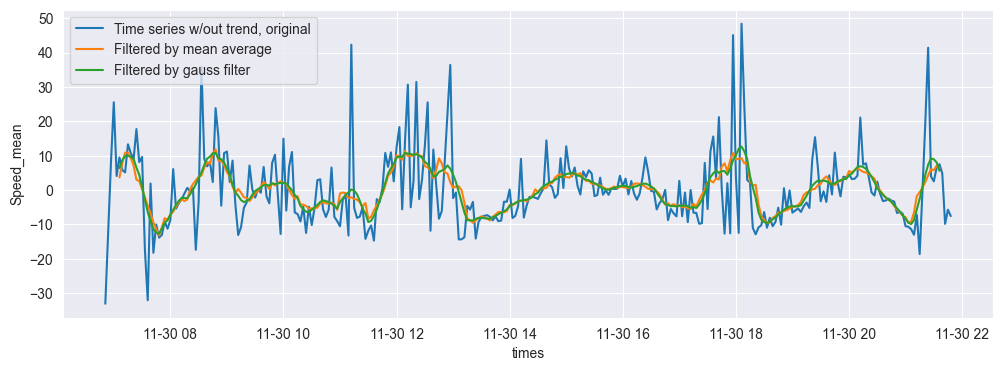

In [43]:
for feat in target+predictors:
    plt.figure(figsize=(12,4), dpi= 100)
    sns.lineplot(x=fdata_mod['times'], y=fdata_mod[feat], label='Time series w/out trend, original')
    sns.lineplot(x=fdata_mr['times'], y=fdata_mr[feat], label='Filtered by mean average')
    sns.lineplot(x=fdata_gauss['times'], y=fdata_gauss[feat], label='Filtered by gauss filter')
    plt.legend(loc = 2)

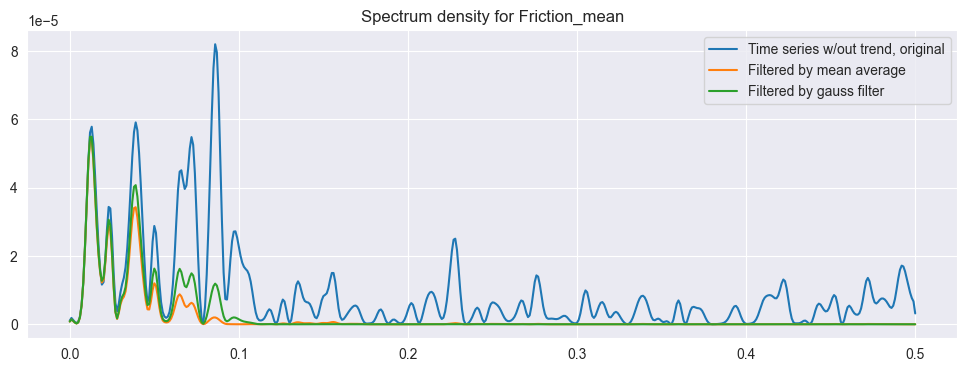

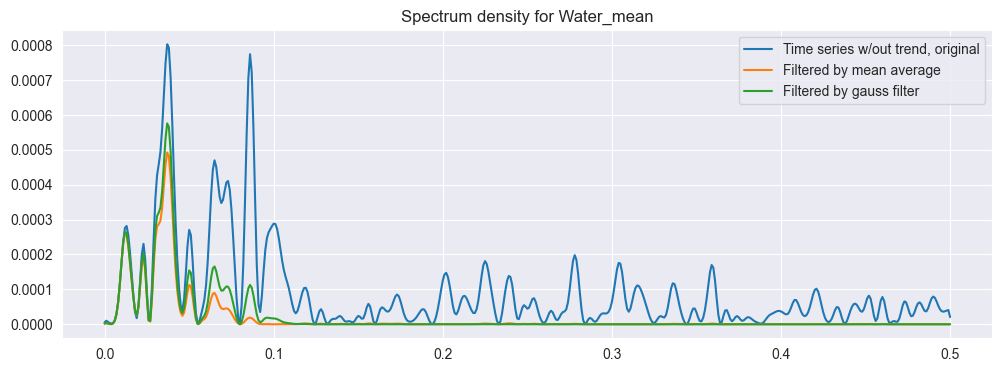

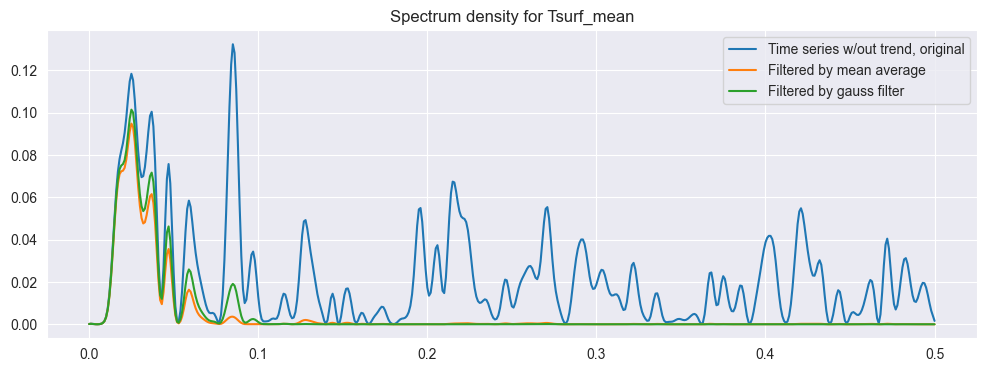

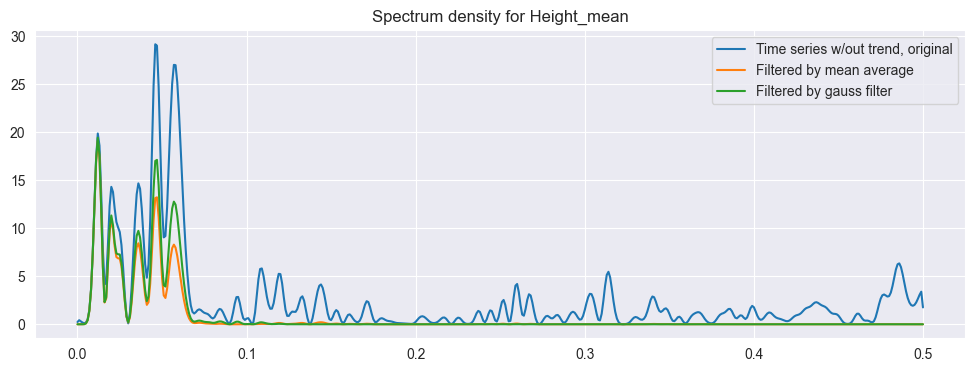

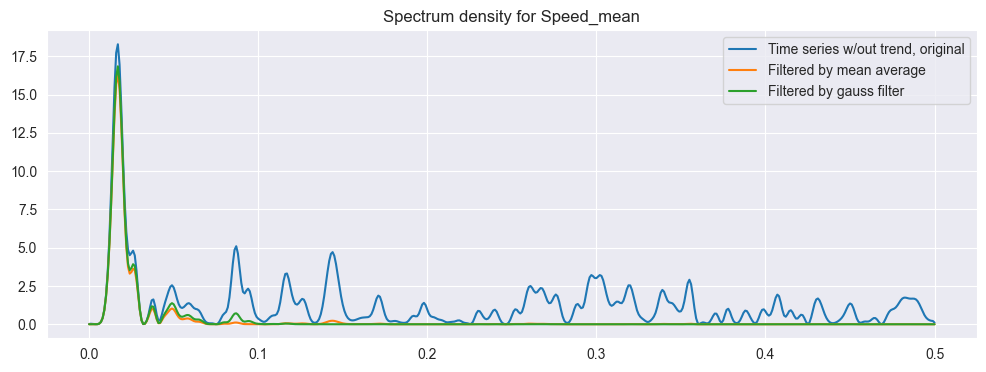

In [44]:
for feat in target+predictors:
    plt.figure(figsize=(12,4), dpi= 100)
    f_raw, Pxx_raw = signal.welch(fdata_mod[feat], fs=1, scaling='spectrum', nfft = 1000)
    f_mr, Pxx_mr = signal.welch(fdata_mr[feat], fs=1, scaling='spectrum', nfft = 1000)
    f_gauss, Pxx_gauss = signal.welch(fdata_gauss[feat], fs=1, scaling='spectrum', nfft = 1000)

    sns.lineplot(x=f_raw, y=Pxx_raw, label='Time series w/out trend, original')
    sns.lineplot(x=f_mr, y=Pxx_mr, label='Filtered by mean average')
    sns.lineplot(x=f_gauss, y=Pxx_gauss, label='Filtered by gauss filter')

    plt.title("Spectrum density for "+feat)





 Friction_mean
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  240
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 547.364
Date:                Fri, 09 Dec 2022   AIC                          -1088.728
Time:                        21:52:42   BIC                          -1078.287
Sample:                             0   HQIC                         -1084.521
                                - 240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3782      0.053      7.185      0.000       0.275       0.481
ar.L2          0.1606      0.063      2.560      0.010       0.038       0.284
sigma2         0.0006   3.78e-05  

C:\ifmo\AlgoAnalysisDevelopment\venv\Scripts\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(





 Friction_mean
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  232
Model:               SARIMAX(3, 0, 4)   Log Likelihood                1159.825
Date:                Fri, 09 Dec 2022   AIC                          -2301.649
Time:                        21:52:48   BIC                          -2270.628
Sample:                             0   HQIC                         -2289.139
                                - 232                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.283e-05      0.000     -0.093      0.926      -0.000       0.000
ar.L1          2.2232      0.144     15.426      0.000       1.941       2.506
ar.L2         -1.7437      0.258  

C:\ifmo\AlgoAnalysisDevelopment\venv\Scripts\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(





 Water_mean
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  240
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 272.020
Date:                Fri, 09 Dec 2022   AIC                           -534.039
Time:                        21:52:53   BIC                           -516.636
Sample:                             0   HQIC                          -527.027
                                - 240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4559      0.184      7.922      0.000       1.096       1.816
ar.L2         -0.6927      0.136     -5.092      0.000      -0.959      -0.426
ma.L1         -1.1970      0.185     

C:\ifmo\AlgoAnalysisDevelopment\venv\Scripts\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(





 Water_mean
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  232
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 892.870
Date:                Fri, 09 Dec 2022   AIC                          -1767.740
Time:                        21:53:02   BIC                          -1736.720
Sample:                             0   HQIC                         -1755.230
                                - 232                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    4.41e-06      0.000      0.011      0.991      -0.001       0.001
ar.L1          2.3653      0.108     21.889      0.000       2.154       2.577
ar.L2         -2.0440      0.195    -

C:\ifmo\AlgoAnalysisDevelopment\venv\Scripts\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(





 Tsurf_mean
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  240
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -394.064
Date:                Fri, 09 Dec 2022   AIC                            792.128
Time:                        21:53:02   BIC                            799.090
Sample:                             0   HQIC                           794.933
                                - 240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2098      0.072      2.903      0.004       0.068       0.352
sigma2         1.5617      0.080     19.636      0.000       1.406       1.718
Ljung-Box (L1) (Q):                  

C:\ifmo\AlgoAnalysisDevelopment\venv\Scripts\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(





 Tsurf_mean
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  232
Model:               SARIMAX(4, 0, 3)   Log Likelihood                 272.786
Date:                Fri, 09 Dec 2022   AIC                           -527.572
Time:                        21:53:11   BIC                           -496.551
Sample:                             0   HQIC                          -515.062
                                - 232                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0016      0.006     -0.247      0.805      -0.014       0.011
ar.L1          1.6286      0.088     18.505      0.000       1.456       1.801
ar.L2         -0.0837      0.132     

C:\ifmo\AlgoAnalysisDevelopment\venv\Scripts\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


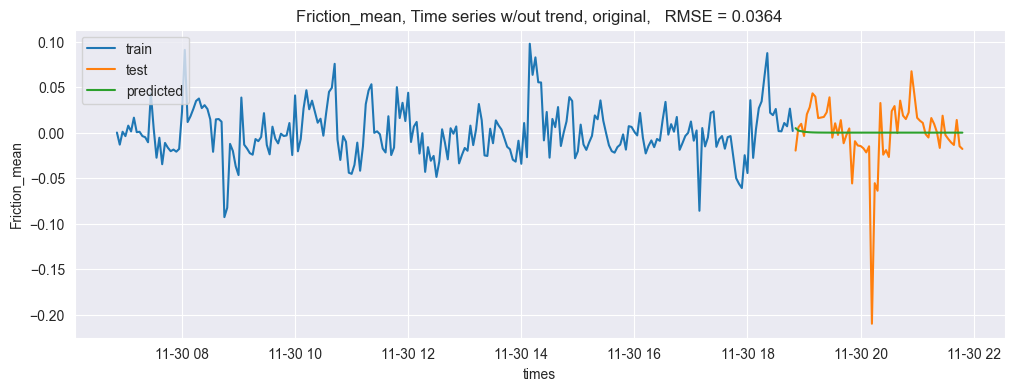

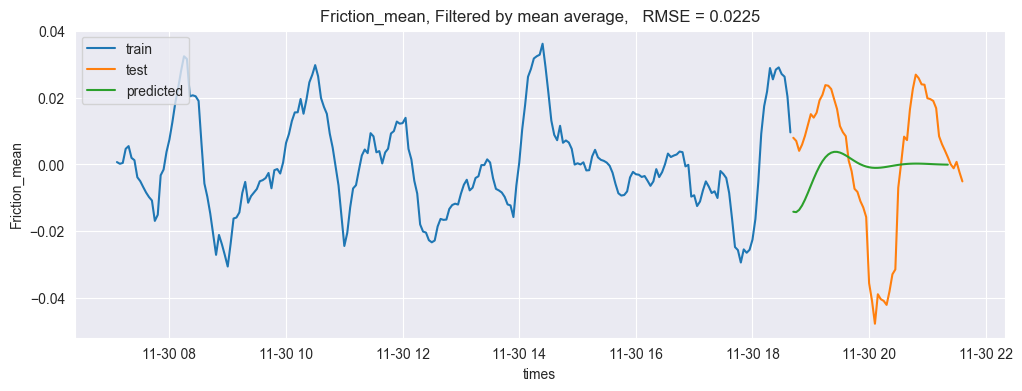

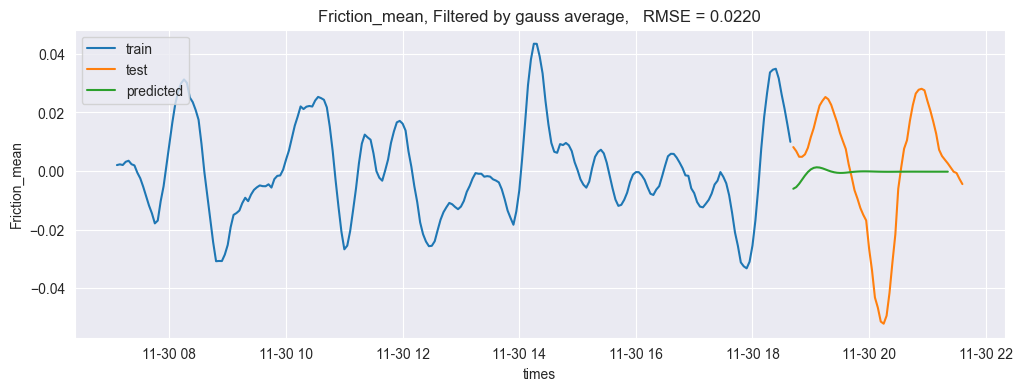

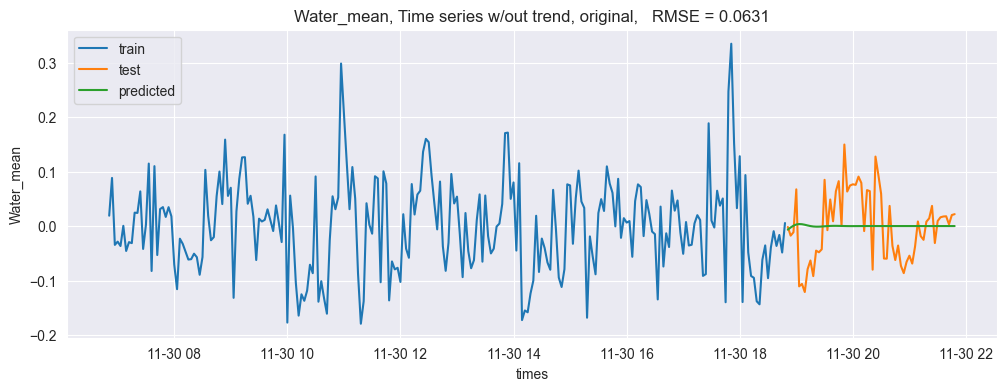

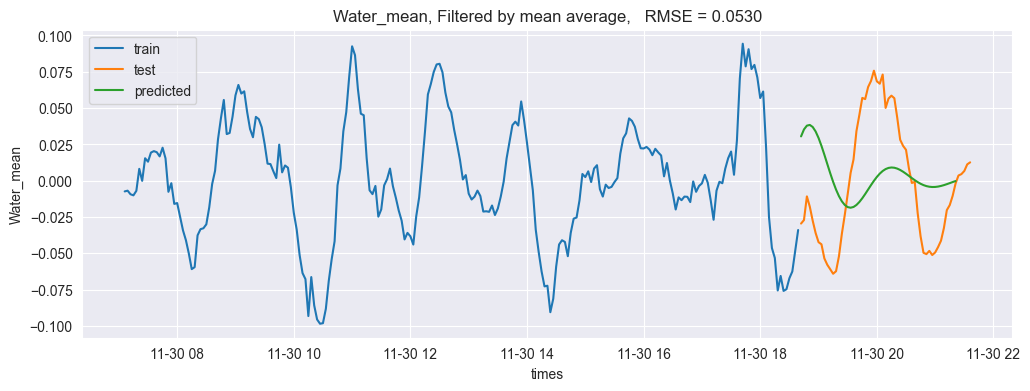

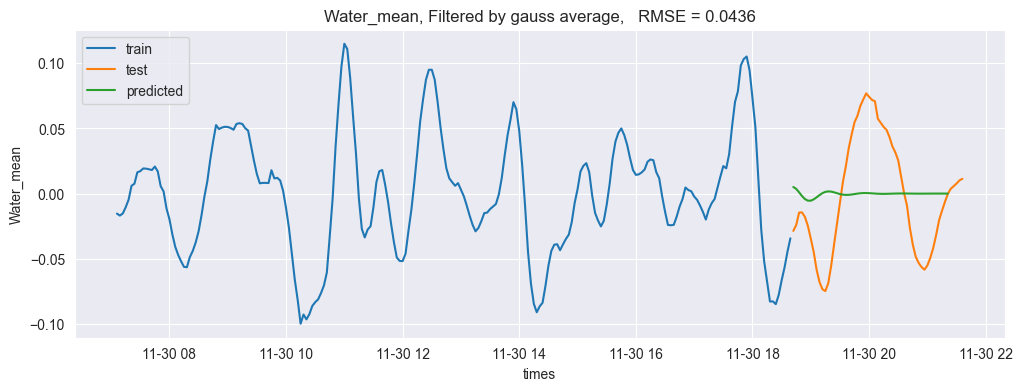

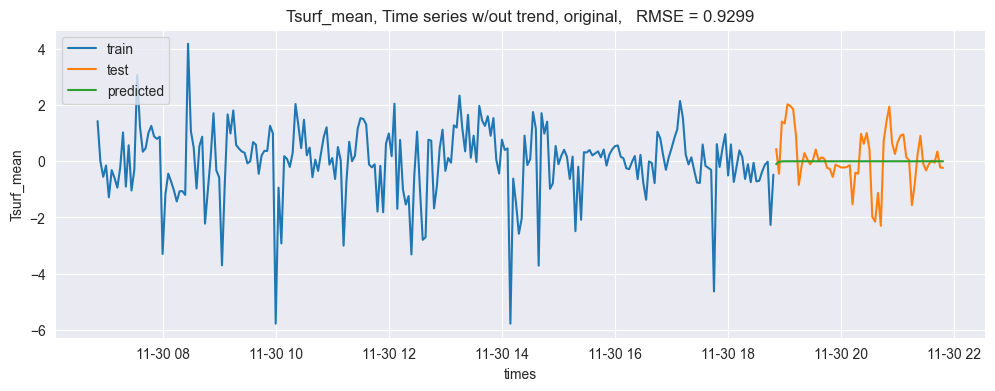

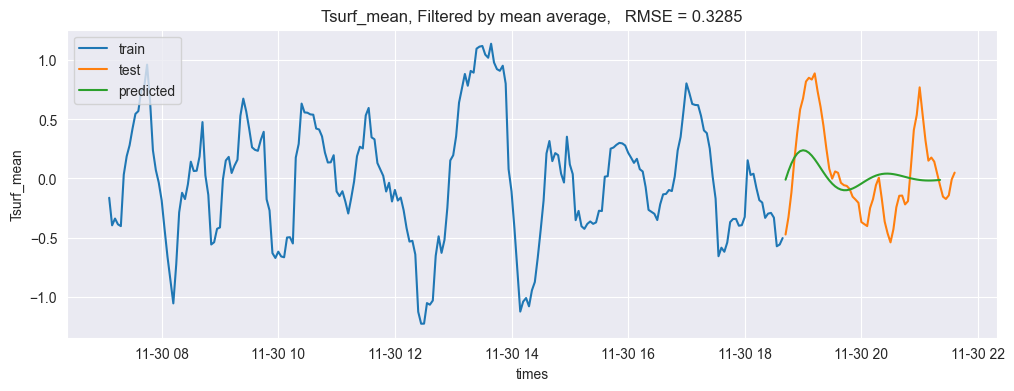

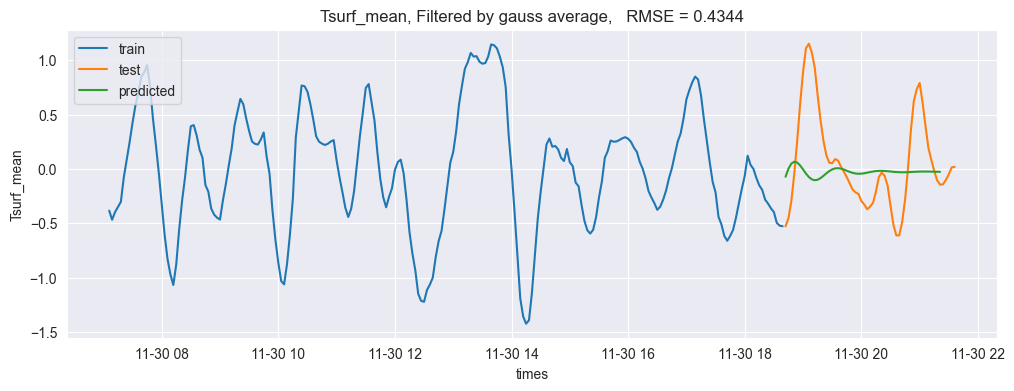

In [45]:
data_label = ['Time series w/out trend, original', 'Filtered by mean average', 'Filtered by gauss average']
datasets = [fdata_mod, fdata_mr, fdata_gauss]
for trg in target:
    for k, dataset in enumerate(datasets):
        cur_time = time.time()
        time_train, time_test, trg_train, trg_test = train_test_split(dataset['times'], dataset[trg], test_size=0.2, shuffle=False)

        #D = pm.arima.nsdiffs(trg_train, m=12, max_D=5)

        stepwise_model = pm.auto_arima(trg_train, d=0,
                                start_p=3, max_p=12,
                                start_q=3, max_q=12,
                                stationary=True,
                                information_criterion='aic',
                                stepwise=True,
                                suppress_warnings=True)
        print("\n\n\n", trg)

        stepwise_model.fit(trg_train)
        print(stepwise_model.summary(), "\n\n\n")

        pred = stepwise_model.predict(len(trg_test))

        delta_time = time.time() - cur_time
        print(f"ARIMA Model for {trg} done in {delta_time} seconds.")


        plt.figure(figsize=(12,4), dpi= 100)

        RMSE = rmse(pred, trg_test)
        plt.title(f"{trg}, {data_label[k]},   RMSE = {RMSE:.4f}")
        sns.lineplot(x=time_train, y=trg_train, label='train')
        sns.lineplot(x=time_test, y=trg_test, label='test')
        sns.lineplot(x=time_test, y=pred, label='predicted')
        plt.legend(loc = 2)




 Friction_mean
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  240
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 547.364
Date:                Fri, 09 Dec 2022   AIC                          -1088.728
Time:                        23:09:15   BIC                          -1078.287
Sample:                             0   HQIC                         -1084.521
                                - 240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3782      0.053      7.185      0.000       0.275       0.481
ar.L2          0.1606      0.063      2.560      0.010       0.038       0.284
sigma2         0.0006   3.78e-05  

C:\ifmo\AlgoAnalysisDevelopment\venv\Scripts\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(





 Friction_mean
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  232
Model:               SARIMAX(2, 0, 0)   Log Likelihood                1135.387
Date:                Fri, 09 Dec 2022   AIC                          -2264.773
Time:                        23:10:05   BIC                          -2254.433
Sample:                             0   HQIC                         -2260.603
                                - 232                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8406      0.027     69.434      0.000       1.789       1.893
ar.L2         -0.9123      0.026    -35.027      0.000      -0.963      -0.861
sigma2       3.19e-06   2.86e-07  

C:\ifmo\AlgoAnalysisDevelopment\venv\Scripts\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(





 Water_mean
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  240
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 272.020
Date:                Fri, 09 Dec 2022   AIC                           -534.039
Time:                        23:10:16   BIC                           -516.636
Sample:                             0   HQIC                          -527.027
                                - 240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4559      0.184      7.922      0.000       1.096       1.816
ar.L2         -0.6927      0.136     -5.092      0.000      -0.959      -0.426
ma.L1         -1.1970      0.185     

C:\ifmo\AlgoAnalysisDevelopment\venv\Scripts\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(





 Water_mean
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  232
Model:               SARIMAX(3, 0, 4)   Log Likelihood                 892.870
Date:                Fri, 09 Dec 2022   AIC                          -1767.740
Time:                        23:10:35   BIC                          -1736.720
Sample:                             0   HQIC                         -1755.230
                                - 232                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    4.41e-06      0.000      0.011      0.991      -0.001       0.001
ar.L1          2.3653      0.108     21.889      0.000       2.154       2.577
ar.L2         -2.0440      0.195    -

C:\ifmo\AlgoAnalysisDevelopment\venv\Scripts\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(





 Tsurf_mean
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  240
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -392.028
Date:                            Fri, 09 Dec 2022   AIC                            790.055
Time:                                    23:10:38   BIC                            800.497
Sample:                                         0   HQIC                           794.263
                                            - 240                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1988      0.073      2.731      0.006       0.056       0.341
ar.S.L12      -0.129

C:\ifmo\AlgoAnalysisDevelopment\venv\Scripts\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(





 Tsurf_mean
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  232
Model:               SARIMAX(4, 0, 3)   Log Likelihood                 272.786
Date:                Fri, 09 Dec 2022   AIC                           -527.572
Time:                        23:11:02   BIC                           -496.551
Sample:                             0   HQIC                          -515.062
                                - 232                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0016      0.006     -0.247      0.805      -0.014       0.011
ar.L1          1.6286      0.088     18.505      0.000       1.456       1.801
ar.L2         -0.0837      0.132     

C:\ifmo\AlgoAnalysisDevelopment\venv\Scripts\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


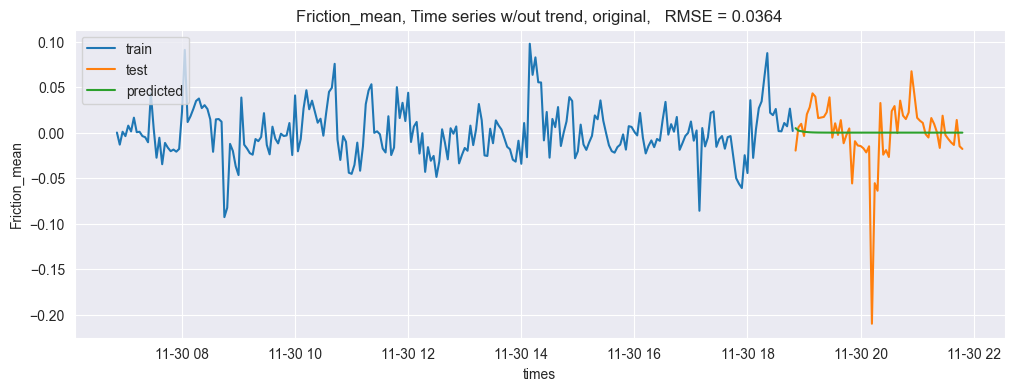

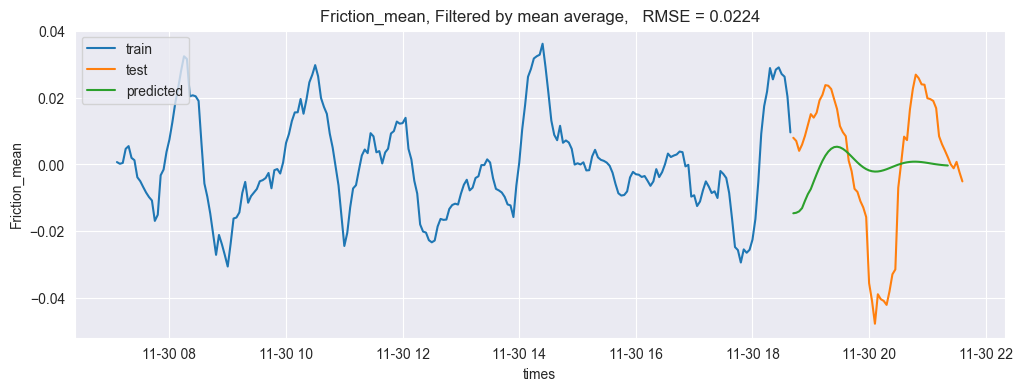

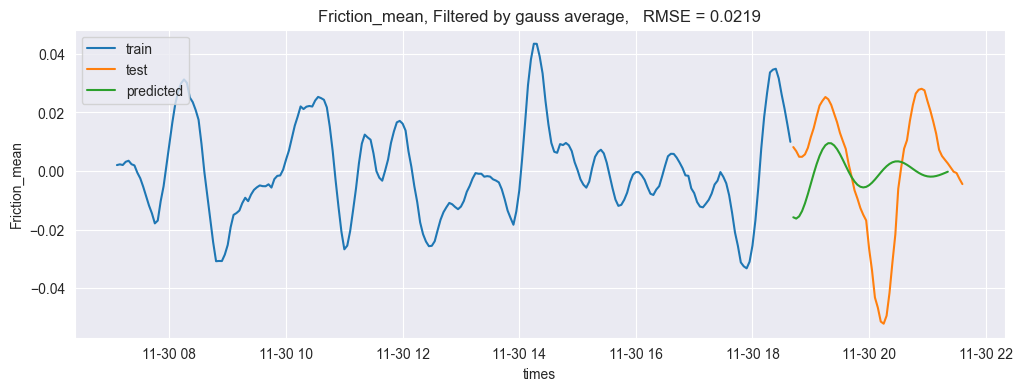

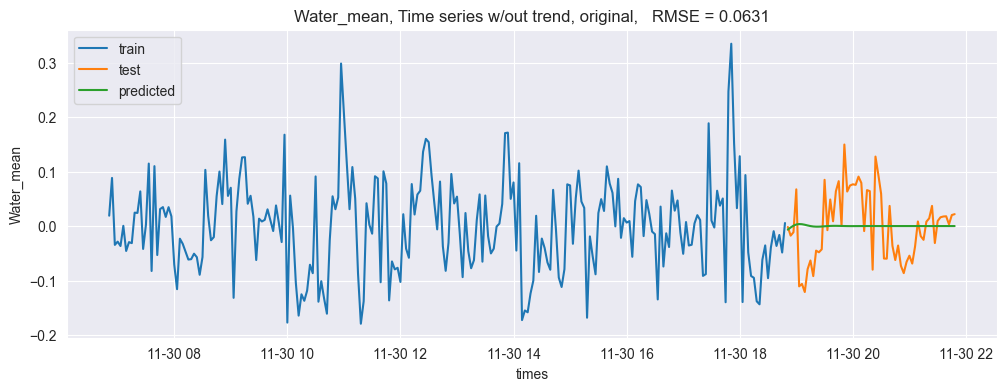

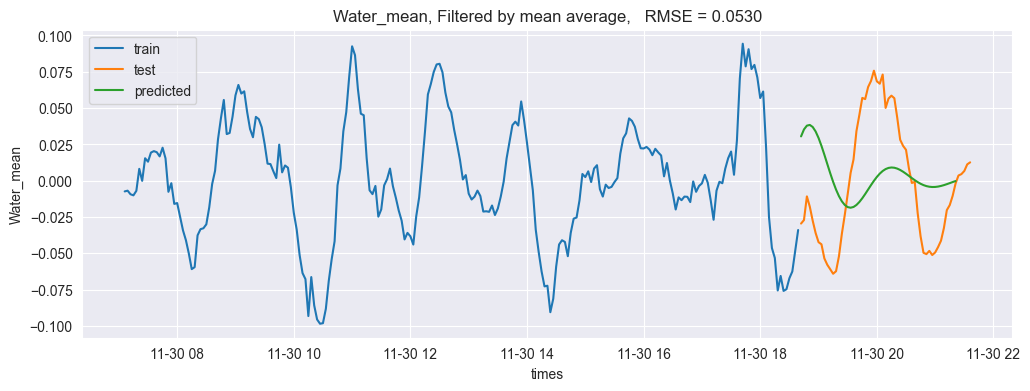

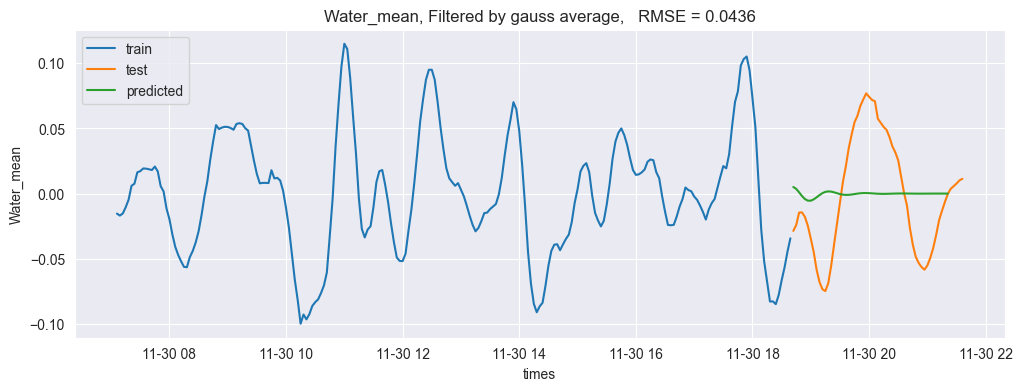

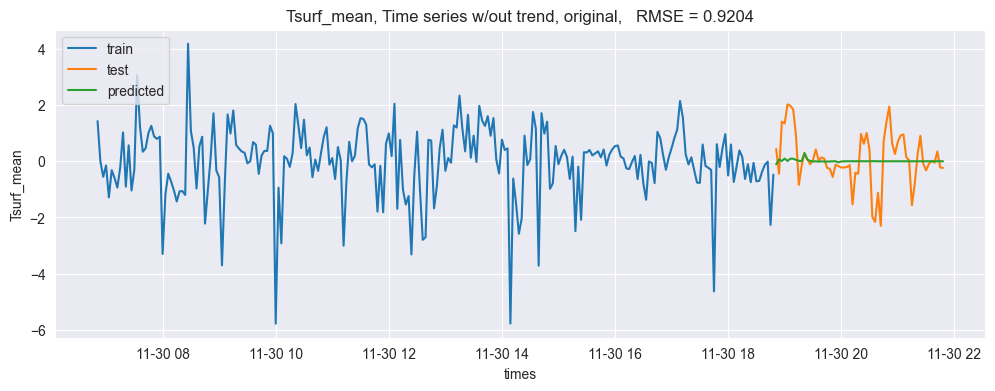

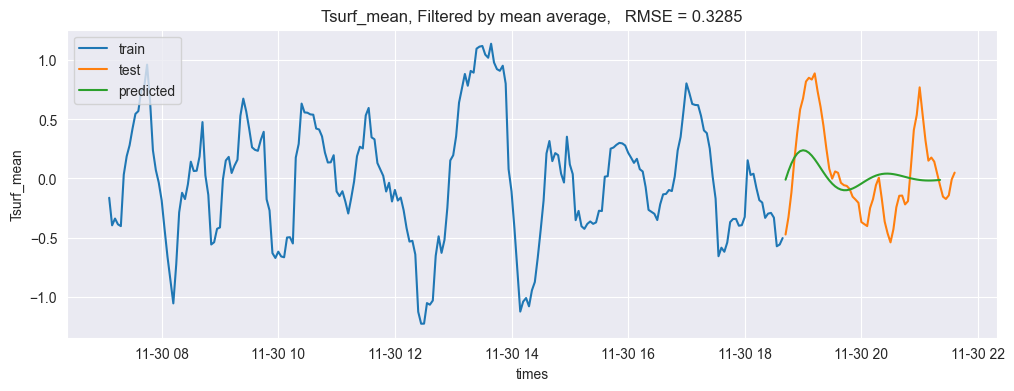

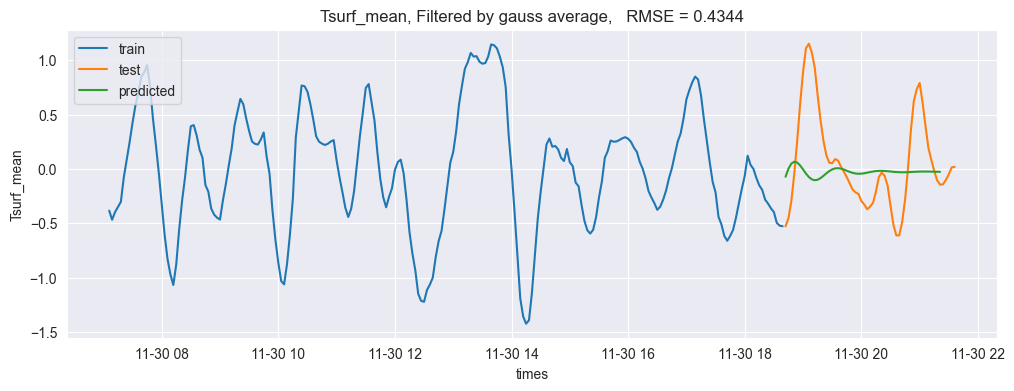

In [47]:
data_label = ['Time series w/out trend, original', 'Filtered by mean average', 'Filtered by gauss average']
datasets = [fdata_mod, fdata_mr, fdata_gauss]
models = []
for trg in target:
    for k, dataset in enumerate(datasets):
        cur_time = time.time()
        time_train, time_test, trg_train, trg_test = train_test_split(dataset['times'], dataset[trg], test_size=0.2, shuffle=False)

        D = pm.arima.nsdiffs(trg_train, m=12, max_D=5)

        stepwise_model = pm.auto_arima(trg_train, d=0, start_p=3, max_p=12, start_q=3, max_q=12, D=D, m=12,
                                stationary=True, seasonal=True, information_criterion='aic', stepwise=True, suppress_warnings=True)
        print("\n\n\n", trg)

        stepwise_model.fit(trg_train)
        print(stepwise_model.summary(), "\n\n\n")

        models.append(stepwise_model)

        pred = stepwise_model.predict(len(trg_test))

        delta_time = time.time() - cur_time
        print(f"ARIMA Model for {trg} done in {delta_time} seconds.")


        plt.figure(figsize=(12,4), dpi= 100)

        RMSE = rmse(pred, trg_test)
        plt.title(f"{trg}, {data_label[k]},   RMSE = {RMSE:.4f}")
        sns.lineplot(x=time_train, y=trg_train, label='train')
        sns.lineplot(x=time_test, y=trg_test, label='test')
        sns.lineplot(x=time_test, y=pred, label='predicted')
        plt.legend(loc = 2)